# Pressor Distributions
- Ruoyi Jiang
- July 19, 2019
- Evaluation of the different pressor combinations used in MIMIC

In [611]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(fasttime)
library(epitools)

Filtering criteria:
- Groupby continuous courses (<24 hour intervals between pressors not considered separate)
- Exclude those on pressors within 1 hr of hospital
- First pressor course

In [348]:
pressors_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/pressors.csv')

In [327]:
dim(pressors_df)

[1] 227645     11

In [328]:
pressors_df %>%
    filter(pressor == "central_line_durations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
30584,central_line_durations,0,70.91667,2181-11-28 20:59:00,200001,NA,central_line_durations,2181-11-25 22:04:00,NA,NA
30585,central_line_durations,1,134.00000,2199-08-08 15:00:00,200003,NA,central_line_durations,2199-08-03 01:00:00,NA,NA
30586,central_line_durations,2,37.75000,2189-12-02 08:00:00,200009,NA,central_line_durations,2189-11-30 18:15:00,NA,NA
30587,central_line_durations,3,19.68333,2132-08-05 20:36:00,200010,NA,central_line_durations,2132-08-05 00:55:00,NA,NA
30588,central_line_durations,4,23.76667,2114-12-27 22:46:00,200021,NA,central_line_durations,2114-12-26 23:00:00,NA,NA
30589,central_line_durations,5,9.30000,2127-03-04 01:18:00,200024,NA,central_line_durations,2127-03-03 16:00:00,NA,NA


In [329]:
pressors_df %>%
    filter(pressor == 'norepinephrinedurations')  %>%
    mutate(SHORT = duration_hours < 24) %>%
    group_by(SHORT) %>% 
    summarize(COUNT = n())

SHORT,COUNT
<lgl>,<int>
FALSE,3407
TRUE,19781


### Available pressor (and other infusions) choices

In [227]:
unique(pressors_df$pressor)

[1] adenosinedurations      arterial_line_durations central_line_durations 
 [4] crrtdurations           dobutaminedurations     dopaminedurations      
 [7] epinephrinedurations    isupreldurations        milrinonedurations     
[10] norepinephrinedurations phenylephrinedurations  vasopressindurations   
[13] vasopressordurations    ventdurations          
14 Levels: adenosinedurations ... ventdurations

# Histograms of pressor durations for norepi

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 496 rows containing non-finite values (stat_bin).”Warning message:
“Removed 496 rows containing non-finite values (stat_density).”

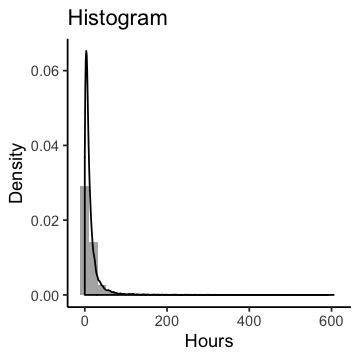

In [15]:
options(repr.plot.width=3, repr.plot.height=3)
pressors_df %>%
    filter('norepinephrinedurations' == pressor) %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    ggplot(aes(x=DIFF)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic()

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


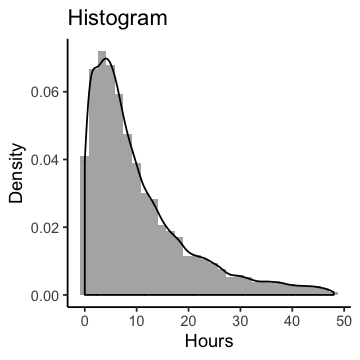

In [16]:
options(repr.plot.width=3, repr.plot.height=3)
pressors_df %>%
    filter('norepinephrinedurations' == pressor) %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    filter(DIFF < 48) %>%
    ggplot(aes(x=DIFF)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic()

### Join with icustay metadata

In [349]:
lengthstay_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/length_stay.csv') %>%
    rename(icustarttime = START, icuendtime = END)

In [350]:
lengthstay_df %>% head()

X,icustay_id,icustarttime,icuendtime,DIFF
<int>,<int>,<fct>,<fct>,<dbl>
1,200001,2181-11-25 19:06:00,2181-11-28 20:00:00,72.90000
2,200003,2199-08-02 19:15:00,2199-08-08 15:00:00,139.75000
3,200006,2159-09-03 12:30:00,2159-09-04 17:00:00,28.50000
4,200007,2109-02-17 09:00:00,2109-02-18 09:15:00,24.25000
5,200009,2189-11-30 11:43:00,2189-12-02 13:00:00,49.28333
6,200010,2132-08-05 00:39:00,2132-08-05 21:17:00,20.63333


In [452]:
# filter by pressor and left join with lengthstay_df
input_df <- pressors_df %>%
    filter('norepinephrinedurations' == pressor) %>%
    left_join(lengthstay_df, by = "icustay_id") %>%
    mutate(starttime = fastPOSIXct(starttime), endtime = fastPOSIXct(endtime), 
           icustarttime = fastPOSIXct(icustarttime), icuendtime = fastPOSIXct(icuendtime))

# Analyze Filters (7/31/19)

#### Collapse pressor courses based on length of intervening time (<24 hrs)
- Any two courses with less than intervening 24 hours will be collapsed into a single course within an icustay

In [453]:
max_intervening_hrs <- 24

# find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# use a cumsum to create a new id separating courses that are separated by more than >24
input_df <- input_df %>%
    group_by(icustay_id) %>%
    mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
    rowwise() %>%
    mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
    ungroup() %>%
    group_by(icustay_id) %>%
    mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)

In [454]:
# input_df %>%
#     filter(icustay_id %in% c(299386, 299415, 200206)) %>%
#     mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
#     rowwise() %>%
#     mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
#     ungroup() %>%
#     group_by(icustay_id) %>%
#     mutate(continuous_course = cumsum(increasing))

- the combination of **continuous course** and **icustay_id** (e.g. 200024, 0 for first row) now defines each pressor course

- assign boolean assessments after <24 hour intervals between pressors are removed
    1. more or less than 24 hours of pressor duration?
    2. is this the first pressor course?
    3. are pressors administered <1 hr of the icustay?

In [455]:
# 1. more or less than 24 hours?
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24)

In [456]:
# 2. first pressor course? (groupby icustay, filter min starttime == starttime)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(FIRSTCOURSE = min(coursestarttime) == coursestarttime)

In [457]:
# 3. pressors within 1 hr of icustay_id? (groupby icustay, filter max starttime - unique icustarttime > 1)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(LESS1HOUR = difftime(min(coursestarttime), 
                         min(icustarttime)) < 1)

In [458]:
# grouped by icustay_id + continuous_course + separate_course
input_df %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = n())

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,876
FALSE,FALSE,TRUE,2077
FALSE,TRUE,FALSE,5357
FALSE,TRUE,TRUE,12605
TRUE,FALSE,FALSE,35
TRUE,FALSE,TRUE,69
TRUE,TRUE,FALSE,356
TRUE,TRUE,TRUE,455
NA,FALSE,FALSE,65


In [459]:
# With filters grouped by icustay_id + continuous_course
input_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,583
FALSE,FALSE,TRUE,489
FALSE,TRUE,FALSE,3700
FALSE,TRUE,TRUE,2918
TRUE,FALSE,FALSE,22
TRUE,FALSE,TRUE,12
TRUE,TRUE,FALSE,268
TRUE,TRUE,TRUE,135
NA,FALSE,FALSE,44


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing missing values (geom_bar).”

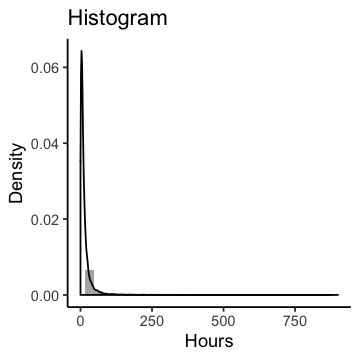

In [285]:
options(repr.plot.width=3, repr.plot.height=3)
input_df %>%
    ggplot(aes(x=duration_hours)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic() + xlim(0, 900)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

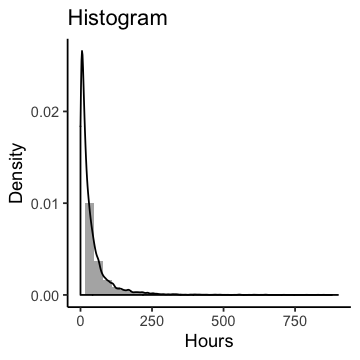

In [286]:
options(repr.plot.width=3, repr.plot.height=3)
input_df %>%
    group_by(icustay_id, continuous_course) %>%
    summarize(duration_hours = sum(duration_hours)) %>%
    ggplot(aes(x=duration_hours)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic() + xlim(0, 900)

In [132]:
#write.csv(input_df, '~/Projects/Haimovich_Pressors/collection/out/pressors_filtered.csv')

### Mortality filter
- Remove patients who stopped using pressors because death (merge with pressors_df by icustay_id, filter if pressor course end time == or is close to deathtime)

In [390]:
icustays_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/icustays.csv')

In [391]:
admissions_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/admissions.csv')

In [575]:
patients_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/patients.csv')

In [598]:
nonvitals_predictor_df <- icustays_df %>%
    select(hadm_id, icustay_id, first_careunit, last_careunit) %>%
    left_join(admissions_df, by = 'hadm_id') %>%
    left_join(patients_df, by = 'subject_id') %>%
    mutate(deathtime = fastPOSIXct(deathtime), admittime = fastPOSIXct(admittime), dob = fastPOSIXct(dob)) %>%
    mutate(age = difftime(admittime, dob, units="weeks")/52.25, age_cohort = as.numeric(round(age, digits = -1)))

In [355]:
# just some cool info about what each service covers which diagnoses
nonvitals_predictor_df %>% 
    group_by(diagnosis, first_careunit) %>% 
    summarize(COUNT = n()) %>% 
    arrange(-COUNT) %>% head(10)

diagnosis,first_careunit,COUNT
<fct>,<fct>,<int>
NEWBORN,NICU,7840
PNEUMONIA,MICU,1365
SEPSIS,MICU,1026
CORONARY ARTERY DISEASE,CSRU,755
GASTROINTESTINAL BLEED,MICU,613
CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS GRAFT /SDA,CSRU,591
ALTERED MENTAL STATUS,MICU,559
CONGESTIVE HEART FAILURE,CCU,501
UPPER GI BLEED,MICU,482


In [422]:
#NA means the stay did not end in death
#ICUSTAYS where patient was discharged after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, dischtime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,5330
TRUE,1132
NA,55070


In [423]:
#NA means the stay did not end in death
#ICUSTAYS where patient was admitted after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, admittime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,6384
TRUE,78
NA,55070


In [424]:
#Examples
nonvitals_predictor_df  %>%
    filter(difftime(deathtime, admittime, units = "mins") < 0) %>%
    head(5)

hadm_id,icustay_id,first_careunit,last_careunit,X,row_id,subject_id,admittime,dischtime,deathtime,⋯,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dttm>,<fct>,<dttm>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>
102631,246694,CSRU,CSRU,456,237,181,2153-10-12 05:49:00,2153-10-12 06:29:00,2153-10-12 02:29:00,⋯,Private,,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1
138015,298263,NICU,NICU,1911,1640,1334,2137-09-02 10:43:00,2137-09-02 12:00:00,2137-09-02 08:00:00,⋯,Private,,PROTESTANT QUAKER,,WHITE,,,NEWBORN,1,1
181430,291798,SICU,SICU,1970,1699,1381,2189-01-02 09:25:00,2189-01-02 12:00:00,2189-01-02 07:00:00,⋯,Medicare,,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1
187482,213831,MICU,MICU,693,644,516,2197-07-31 16:18:00,2197-07-31 01:10:00,2197-07-30 21:10:00,⋯,Medicare,,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0
190088,293048,CCU,CCU,3624,3447,2858,2108-09-25 11:29:00,2108-09-25 12:00:00,2108-09-25 08:00:00,⋯,Medicare,,CATHOLIC,WIDOWED,WHITE,,,MYOCARDIAL INFARCTION\CATH,1,1


### Setting a mortality filter

In [434]:
# Icustays where patients received pressors after death (TRUE)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    mutate(STOPMORTALITY = difftime(deathtime, endtime, units = "mins")) %>% 
    group_by(STOPMORTALITY < 0) %>%
    summarize(COUNT = length(unique(icustay_id)))

STOPMORTALITY < 0,COUNT
<lgl>,<int>
FALSE,2430
TRUE,437
NA,4689


In [436]:
### if I do not ignore for these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,8202
TRUE,1768
NA,13218


In [437]:
### if I do ignore these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY > 0 &  STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,9867
TRUE,103
NA,13218


In [601]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [602]:
input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,545
FALSE,FALSE,FALSE,TRUE,448
FALSE,FALSE,TRUE,FALSE,38
FALSE,FALSE,TRUE,TRUE,41
FALSE,TRUE,FALSE,FALSE,3448
FALSE,TRUE,FALSE,TRUE,2743
FALSE,TRUE,TRUE,FALSE,252
FALSE,TRUE,TRUE,TRUE,175
TRUE,FALSE,FALSE,FALSE,21


In [600]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [479]:
input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,578
FALSE,FALSE,FALSE,TRUE,485
FALSE,FALSE,TRUE,FALSE,5
FALSE,FALSE,TRUE,TRUE,4
FALSE,TRUE,FALSE,FALSE,3683
FALSE,TRUE,FALSE,TRUE,2909
FALSE,TRUE,TRUE,FALSE,17
FALSE,TRUE,TRUE,TRUE,9
TRUE,FALSE,FALSE,FALSE,22


### Use filters

In [603]:
output_df <- input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(course_id) %>%
    mutate(starttime = min(starttime), endtime = max(endtime)) %>%
    filter(!LESS1HOUR, FIRSTCOURSE, !STOPMORTALITY) 

# Possible predictors for >24 hrs of pressor usage
- Age, sex, ethnicity
    - to handle age, need to subtract icustarttime from dob as years. Then group round to nearest 10. 
- Vital signs at 2,4,6,12 hrs before pressor initiation (or a log reg of this) (vitals_df)
- Diagnosis code (nonvitals_predictor_df)

### Gender effect, greater risk for Male (chi-square, relative risk)

In [629]:
gender_df <- output_df %>%
    group_by(MORETHAN24HOURS, gender) %>%
    summarize(COUNT = n())

#### Chi-Square (Significant) "there is an interaction between sex and response"

In [678]:
gender_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test with Yates' continuity correction

data:  .
X-squared = 15.118, df = 1, p-value = 0.000101


#### Relative risk (Significant) "there is a different RR for male compared to female for the response"

In [631]:
gender_df %>%
    spread(MORETHAN24HOURS, COUNT) %>%
    tibble::column_to_rownames("gender") %>%
    as.matrix() %>% riskratio()

,FALSE,TRUE,Total
F,2161,4705,6866
M,2789,6943,9732
Total,4950,11648,16598
,estimate,lower,upper
F,1.000000,NA,NA
M,1.041092,1.020085,1.062532
,midp.exact,fisher.exact,chi.square
F,NA,NA,NA
M,9.631229e-05,9.888139e-05,9.405792e-05


### Race, greater risk for Black (chi-square, relative risk)
- ASIAN (grepl ASIAN), BLACK (grepl BLACK), HISPANIC (grepl HISPANIC), WHITE (grepl WHITE)

In [666]:
races <- c("ASIAN", "BLACK", "HISPANIC", "WHITE", "OTHER")

simplifyRace <- function(ethnicity){
    if(grepl("ASIAN", ethnicity)){return("ASIAN")}
    else if(grepl("BLACK", ethnicity)){return("BLACK")}
    else if(grepl("HISPANIC", ethnicity)){return("HISPANIC")}
    else if(grepl("WHITE", ethnicity)){return("WHITE")}
    else{return("OTHER")}
}

In [659]:
race_df <- output_df %>%
    rowwise() %>%
    mutate(RACE = simplifyRace(ethnicity)) %>%
    group_by(MORETHAN24HOURS, RACE) %>%
    summarize(COUNT = n())

#### Chi-Square (Significant) "there is an interaction between race and response"

In [674]:
race_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("RACE") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test

data:  .
X-squared = 11.889, df = 4, p-value = 0.0182


#### Relative risk (Some significant) "there is a different RR for X race compared to not X races for the response"

In [672]:
for(race in races){
   output <- race_df %>%
        mutate(RACE_BOOL = RACE == race) %>%
        group_by(RACE_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("RACE_BOOL") %>%
        as.matrix() %>% riskratio() 
    cat("\n\n####", race, "####\n\n")
    print(output)
}




#### ASIAN ####

$data
      FALSE  TRUE Total
FALSE  4810 11333 16143
TRUE    140   315   455
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I.  estimate     lower    upper
                   FALSE 1.0000000        NA       NA
                   TRUE  0.9861399 0.9267862 1.049295

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         NA
    TRUE   0.6512484    0.6776775  0.6545643

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### BLACK ####

$data
      FALSE  TRUE Total
FALSE  4544 10538 15082
TRUE    406  1110  1516
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I. estimate    lower  upper
                   FALSE 1.000000       NA     NA
                   TRUE  1.047911 1.014709 1.0822

$p.value
         NA
two-sided  midp.exact fisher.exact  chi.square
    FALSE          NA           NA          NA
  

### Age effect strong for 30s (wilcox, chi-square, RR greater than, RR within group)

In [676]:
age_df <- output_df %>%
    group_by(MORETHAN24HOURS, age_cohort) %>%
    summarize(COUNT = n()) %>%
    drop_na(age_cohort)

#### Wilcox (Significant) "there is an interaction between age and response"

In [638]:
wilcox.test(as.numeric(output_df$age), as.numeric(output_df$MORETHAN24HOURS))


	Wilcoxon rank sum test with continuity correction

data:  as.numeric(output_df$age) and as.numeric(output_df$MORETHAN24HOURS)
W = 263808612, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


#### Chi-square (Significant) "there is an interaction between age cohort and response"

In [677]:
age_df %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("age_cohort") %>%
        as.matrix() %>% chisq.test() 


	Pearson's Chi-squared test

data:  .
X-squared = 143.81, df = 7, p-value < 2.2e-16


#### Relative risk (Some significant) "there is a different RR for X age cohort compared to not X age cohort for the response"
- People in their 30s tend to end up on pressors >24 hrs (not 20s, or >40+)

In [679]:
for(ac in unique(age_df$age_cohort)){
   output <- age_df %>%
        mutate(AGE_BOOL = age_cohort == ac) %>%
        group_by(AGE_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("AGE_BOOL") %>%
        as.matrix() %>% riskratio() 
    cat("\n\n####", ac, "####\n\n")
    print(output)
}



#### 20 ####

$data
      FALSE  TRUE Total
FALSE  4633 11117 15750
TRUE     51    93   144
Total  4684 11210 15894

$measure
                        NA
risk ratio with 95% C.I.  estimate     lower    upper
                   FALSE 1.0000000        NA       NA
                   TRUE  0.9149838 0.8104062 1.033056

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         NA
    TRUE   0.1210691    0.1190291  0.1158809

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### 30 ####

$data
      FALSE  TRUE Total
FALSE  4586 10807 15393
TRUE     98   403   501
Total  4684 11210 15894

$measure
                        NA
risk ratio with 95% C.I. estimate    lower    upper
                   FALSE 1.000000       NA       NA
                   TRUE  1.145738 1.095991 1.197743

$p.value
         NA
two-sided   midp.exact fisher.exact  chi.square
    FALSE           NA           NA          NA


#### Relative risk (Some significant) "there is a different RR for X > age cohort compared to X < age cohort for the response"
- People in their 20-40s tend to end up on pressors >24 hrs (not <20s, or >40s)

In [681]:
for(ac in unique(age_df$age_cohort)){
   output <- age_df %>%
        mutate(AGE_BOOL = age_cohort > ac) %>%
        group_by(AGE_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("AGE_BOOL") %>%
        as.matrix() %>% riskratio() 
    cat("\n\n####", 'greater than', ac, "####\n\n")
    print(output)
}



#### greater than 20 ####

$data
      FALSE  TRUE Total
FALSE    51    93   144
TRUE   4633 11117 15750
Total  4684 11210 15894

$measure
                        NA
risk ratio with 95% C.I. estimate     lower    upper
                   FALSE 1.000000        NA       NA
                   TRUE  1.092916 0.9680013 1.233949

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         NA
    TRUE   0.1210691    0.1190291  0.1158809

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### greater than 30 ####

$data
      FALSE  TRUE Total
FALSE   149   496   645
TRUE   4535 10714 15249
Total  4684 11210 15894

$measure
                        NA
risk ratio with 95% C.I.  estimate   lower     upper
                   FALSE 1.0000000      NA        NA
                   TRUE  0.9136678 0.87474 0.9543279

$p.value
         NA
two-sided   midp.exact fisher.exact   chi.square
    FALSE           N

ERROR: Error in table.margins(x): x is not an array


### PMH and diagnosis

In [695]:
# come up with categories
# infection, blood, other
# assign to word closest (create a minimum distance else other)

[1] "X.x.x"                "level_0"              "level_1"             
 [4] "duration_hours"       "endtime"              "icustay_id"          
 [7] "num"                  "pressor"              "starttime"           
[10] "vasonum"              "ventnum"              "X.y.x"               
[13] "icustarttime"         "icuendtime"           "DIFF"                
[16] "continuous_course"    "MORETHAN24HOURS"      "coursestarttime"     
[19] "FIRSTCOURSE"          "LESS1HOUR"            "hadm_id"             
[22] "first_careunit"       "last_careunit"        "X.x.y"               
[25] "row_id.x"             "subject_id"           "admittime"           
[28] "dischtime"            "deathtime"            "admission_type"      
[31] "admission_location"   "discharge_location"   "insurance"           
[34] "language"             "religion"             "marital_status"      
[37] "ethnicity"            "edregtime"            "edouttime"           
[40] "diagnosis"            "hospital_expire_flag" "has_chartevents_data"
[43] "X.y.y"                "row_id.y"             "gender"              
[46] "dob"                  "dod"                  "dod_hosp"            
[49] "dod_ssn"              "expire_flag"          "age"                 
[52] "age_cohort"           "STOPMORTALITY"        "course_id"

In [696]:
output_df %>%
    group_by(diagnosis) %>%
    summarize(COUNT = n()) %>%
    arrange(-COUNT)

diagnosis,COUNT
<fct>,<int>
SEPSIS,1247
PNEUMONIA,849
CONGESTIVE HEART FAILURE,443
HYPOTENSION,327
PANCREATITIS,314
SUBARACHNOID HEMORRHAGE,308
FEVER,288
ABDOMINAL PAIN,279
CORONARY ARTERY DISEASE,245


## Care unit (MICU and SICU end up >24 hrs pressors, not TSICU, CCU, CSRU)

In [684]:
careunit_df <- output_df %>%
    group_by(MORETHAN24HOURS, first_careunit) %>%
    summarize(COUNT = n())

In [685]:
for(cu in unique(careunit_df$first_careunit)){
   output <- careunit_df%>%
        mutate(CU_BOOL = first_careunit == cu) %>%
        group_by(CU_BOOL, MORETHAN24HOURS) %>%
        summarize(COUNT = sum(COUNT)) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("CU_BOOL") %>%
        as.matrix() %>% riskratio() 
    cat("\n\n####", cu, "####\n\n")
    print(output)
}



#### CCU ####

$data
      FALSE  TRUE Total
FALSE  4309 10203 14512
TRUE    641  1445  2086
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I.  estimate     lower    upper
                   FALSE 1.0000000        NA       NA
                   TRUE  0.9852647 0.9556921 1.015752

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         NA
    TRUE   0.3335555     0.343678  0.3334847

$correction
[1] FALSE

attr(,"method")
[1] "Unconditional MLE & normal approximation (Wald) CI"


#### CSRU ####

$data
      FALSE  TRUE Total
FALSE  3937 10245 14182
TRUE   1013  1403  2416
Total  4950 11648 16598

$measure
                        NA
risk ratio with 95% C.I.  estimate    lower     upper
                   FALSE 1.0000000       NA        NA
                   TRUE  0.8038708 0.775923 0.8328252

$p.value
         NA
two-sided midp.exact fisher.exact chi.square
    FALSE         NA           NA         

# Merge pressor data with vitals and assess possible response (7/29/19)

In [497]:
vitals_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/vitals.csv')

In [517]:
# takes 6 mins to run (because of difftime)

vitals_merged_df <- vitals_df %>%
    mutate(charttime = fastPOSIXct(charttime)) %>%
    filter(icustay_id %in% output_df$icustay_id) %>%
    left_join(select(output_df, icustay_id, starttime, endtime, MORETHAN24HOURS), by = "icustay_id") %>%
    rowwise() %>%
    mutate(diff = difftime(charttime, 
                       starttime, units="hours"))

Adding missing grouping variables: `course_id`


In [518]:
dim(vitals_merged_df)

[1] 8107995      15

In [562]:
intervals <- 1:10

In [563]:
results_list <- list()

In [564]:
for(interval in intervals){
    # 2 mins to run
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, icustay_id) %>%
        summarize(mean_heartrate = mean(heartrate, na.rm=T), 
                  mean_sysbp = mean(sysbp, na.rm=T),
                  mean_diasbp = mean(diasbp, na.rm=T),
                  mean_meanbp = mean(meanbp, na.rm=T), 
                  mean_resprate = mean(resprate, na.rm=T), 
                  mean_tempc = mean(tempc, na.rm=T), 
                  mean_spo2 = mean(spo2, na.rm=T), 
                  mean_glucose = mean(glucose, na.rm=T), 

                  median_heartrate = median(heartrate, na.rm=T), 
                  median_sysbp = median(sysbp, na.rm=T),
                  median_diasbp = median(diasbp, na.rm=T),
                  median_meanbp = median(meanbp, na.rm=T), 
                  median_resprate = median(resprate, na.rm=T), 
                  median_tempc = median(tempc, na.rm=T), 
                  median_spo2 = median(spo2, na.rm=T), 
                  median_glucose = median(glucose, na.rm=T),

                  max_heartrate = max(heartrate, na.rm=T), 
                  max_sysbp = max(sysbp, na.rm=T),
                  max_diasbp = max(diasbp, na.rm=T),
                  max_meanbp = max(meanbp, na.rm=T), 
                  max_resprate = max(resprate, na.rm=T), 
                  max_tempc = max(tempc, na.rm=T), 
                  max_spo2 = max(spo2, na.rm=T), 
                  max_glucose = max(glucose, na.rm=T), 

                  min_heartrate = min(heartrate, na.rm=T), 
                  min_sysbp = min(sysbp, na.rm=T),
                  min_diasbp = min(diasbp, na.rm=T),
                  min_meanbp = min(meanbp, na.rm=T), 
                  min_resprate = min(resprate, na.rm=T), 
                  min_tempc = min(tempc, na.rm=T), 
                  min_spo2 = min(spo2, na.rm=T), 
                  min_glucose = min(glucose, na.rm=T)

                 ) %>%
        mutate(INTERVAL = interval)

}

In [565]:
results_df <- bind_rows(results_list)

### Melt for easier plotting

### Possible testing: Kruskal-Wallis, 

In [566]:
melt_results_df <- results_df %>% 
    gather("ID", "VALUE", -MORETHAN24HOURS, -icustay_id, -INTERVAL)

In [567]:
melt_results_norm_df <- melt_results_df%>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    mutate(VALUE_NORM = (VALUE - mean(VALUE))/sd(VALUE))

In [574]:
melt_results_df %>%
    group_by(MORETHAN24HOURS, ID, INTERVAL) %>%
    summarize(MEAN = mean(VALUE, na.rm = T), SD = sd(VALUE, na.rm = T)) %>%
    rename(HOURSBEFOREPRESSORS = INTERVAL) %>%
    filter(grepl("mean_glucose", ID))

MORETHAN24HOURS,ID,HOURSBEFOREPRESSORS,MEAN,SD
<lgl>,<chr>,<int>,<dbl>,<dbl>
FALSE,mean_glucose,1,165.4726,83.96246
FALSE,mean_glucose,2,163.7545,73.74448
FALSE,mean_glucose,3,160.4873,66.45598
FALSE,mean_glucose,4,155.6969,69.60229
FALSE,mean_glucose,5,155.2493,77.41127
FALSE,mean_glucose,6,147.3717,64.28451
FALSE,mean_glucose,7,153.7551,65.74340
FALSE,mean_glucose,8,148.4077,61.82987
FALSE,mean_glucose,9,147.6668,62.81710


In [607]:
melt_results_df %>%
    group_by(MORETHAN24HOURS, ID, INTERVAL) %>%
    summarize(MEAN = mean(VALUE, na.rm = T), SD = sd(VALUE, na.rm = T)) %>%
    rename(HOURSBEFOREPRESSORS = INTERVAL) %>%
    filter(grepl("mean_heartrate", ID))

MORETHAN24HOURS,ID,HOURSBEFOREPRESSORS,MEAN,SD
<lgl>,<chr>,<int>,<dbl>,<dbl>
FALSE,mean_heartrate,1,91.41500,21.21292
FALSE,mean_heartrate,2,92.21219,21.51887
FALSE,mean_heartrate,3,92.65327,21.08484
FALSE,mean_heartrate,4,93.21743,21.09499
FALSE,mean_heartrate,5,92.31238,21.01638
FALSE,mean_heartrate,6,92.16242,20.68711
FALSE,mean_heartrate,7,91.11147,20.10573
FALSE,mean_heartrate,8,90.84620,20.14667
FALSE,mean_heartrate,9,90.64875,19.89788


In [608]:
melt_results_df %>%
    group_by(MORETHAN24HOURS, ID, INTERVAL) %>%
    summarize(MEAN = mean(VALUE, na.rm = T), SD = sd(VALUE, na.rm = T)) %>%
    rename(HOURSBEFOREPRESSORS = INTERVAL) %>%
    filter(grepl("mean_meanbp", ID))

MORETHAN24HOURS,ID,HOURSBEFOREPRESSORS,MEAN,SD
<lgl>,<chr>,<int>,<dbl>,<dbl>
FALSE,mean_meanbp,1,69.35602,15.60029
FALSE,mean_meanbp,2,68.24777,15.87528
FALSE,mean_meanbp,3,70.48433,15.84340
FALSE,mean_meanbp,4,71.64385,16.91313
FALSE,mean_meanbp,5,72.73630,17.26846
FALSE,mean_meanbp,6,72.56045,15.88373
FALSE,mean_meanbp,7,74.25833,16.76144
FALSE,mean_meanbp,8,74.11508,16.69597
FALSE,mean_meanbp,9,74.70031,16.82940


# Model ideas:
- Age, Sex, Race + Continuous Vitals + Class of Diagnosis

# OLD PLOTTING CODE

In [216]:
diff_melt_results_df <- melt_results_df %>%
    mutate(LESS4H_FAC = if(LESS4H){"ACUTE"}else{"BEFORE"}) %>%
    ungroup() %>%
    select(-LESS4H) %>%
    spread(key=LESS4H_FAC, value=VALUE) %>%
    mutate(DIFF = ACUTE - BEFORE) %>%
    drop_na(DIFF)

In [219]:
diff_melt_results_df %>%
    group_by(ID) %>%
    summarize(MEAN = mean(DIFF), MEDIAN = median(DIFF), SD = sd(DIFF)) %>%
    filter(grepl("mean_", ID))

ID,MEAN,MEDIAN,SD
<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,-5.0795903,-4.6190476,10.5574709
mean_glucose,-1.0703783,-2.0000000,57.3764423
mean_heartrate,0.5978909,-0.2500000,15.0400201
mean_meanbp,-6.2249491,-5.9400000,12.7268102
mean_resprate,-0.1385922,0.0000000,4.6541797
mean_spo2,-0.4325486,0.0000000,4.7919907
mean_sysbp,-10.4044132,-9.5045455,17.7648518
mean_tempc,0.1458291,0.1249992,0.9608547


In [220]:
diff_melt_results_df %>%
    group_by(ID) %>%
    summarize(MEAN = mean(DIFF), MEDIAN = median(DIFF), SD = sd(DIFF)) %>%
    filter(grepl("median_", ID))

ID,MEAN,MEDIAN,SD
<chr>,<dbl>,<dbl>,<dbl>
median_diasbp,-4.72675829,-4.0000000,10.9233758
median_glucose,1.93764511,0.0000000,58.6315656
median_heartrate,0.94528754,0.0000000,16.0242214
median_meanbp,-5.88472780,-5.2500000,13.2660207
median_resprate,-0.04557188,0.0000000,5.0407835
median_spo2,-0.52318959,0.0000000,4.7320416
median_sysbp,-10.12702102,-9.0000000,19.2407517
median_tempc,0.14083532,0.1111094,0.9843607


### Plotting

In [224]:
# icustay_ids being plotted
melt_results_df %>% select(icustay_id) %>% unlist() %>% unique() %>% length()

Adding missing grouping variables: `LESS4H`


[1] 5127

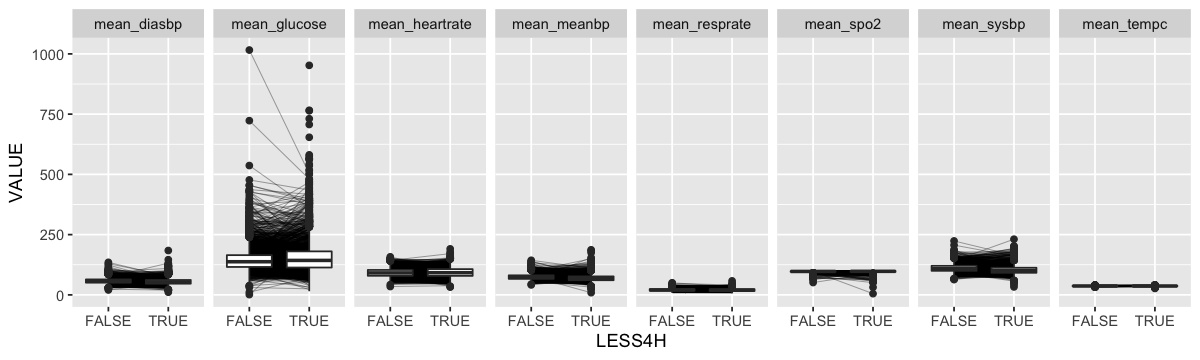

In [177]:
options(repr.plot.width=10, repr.plot.height=3)
melt_results_df %>%
    filter(grepl("mean_", ID)) %>%
    ggplot(aes(x = LESS4H, y = VALUE)) +
    geom_line(aes(group = icustay_id), size = 0.1) +
    geom_boxplot() +
    facet_grid(~ID)

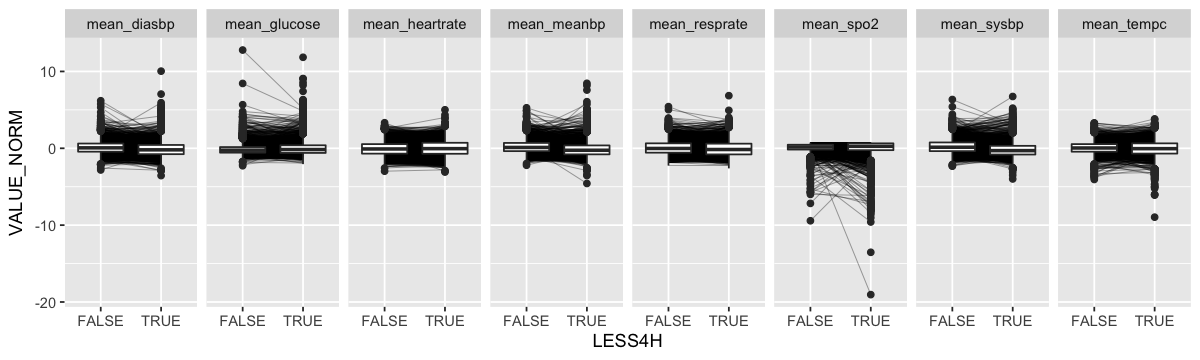

In [184]:
options(repr.plot.width=10, repr.plot.height=3)
melt_results_norm_df %>%
    filter(grepl("mean_", ID)) %>%
    ggplot(aes(x = LESS4H, y = VALUE_NORM)) +
    geom_line(aes(group = icustay_id), size = 0.1) +
    geom_boxplot() +
    facet_grid(~ID)

In [225]:
diff_melt_results_df %>% select(icustay_id) %>% unlist() %>% unique() %>% length()

[1] 2911

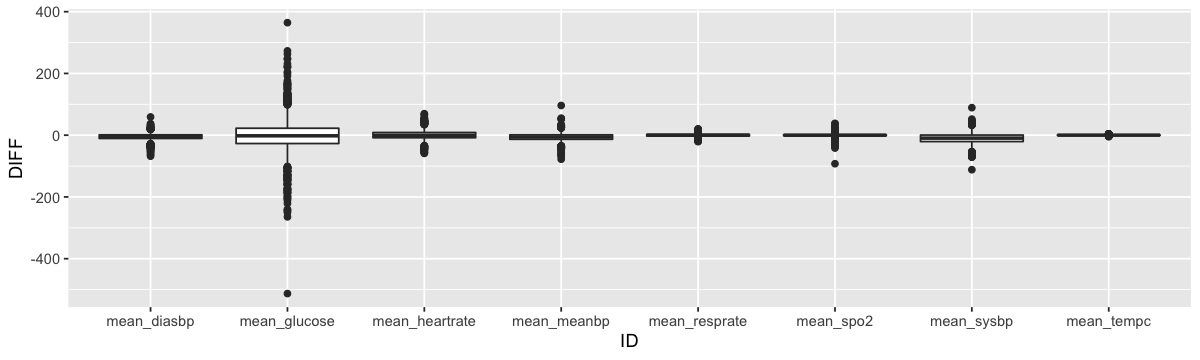

In [218]:
# icustay_ids being plotted
diff_melt_results_df %>%
    filter(grepl("mean_", ID)) %>%
    ggplot(aes(x = ID, y = DIFF)) +
    geom_boxplot()